In [7]:
!wget https://www.dropbox.com/scl/fi/qtcrzmsv4jz47cgvr2t0u/train.zip?rlkey=x3sz1h2o797inkqer67q7dg6b&e=1&st=vp5wa8g9&dl=0

--2024-11-21 08:22:17--  https://www.dropbox.com/scl/fi/qtcrzmsv4jz47cgvr2t0u/train.zip?rlkey=x3sz1h2o797inkqer67q7dg6b
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6ccd364cc2eaad27f27eaeaf30.dl.dropboxusercontent.com/cd/0/inline/CezJRa5BTzHMH1ik-KBikSsHLhW6xVONAHTq-pRSKpo-eBNhBYyET-Eso6F0tT0GAl9YjpcxOnWApZbyt80sEXm_EgBS4pbtRPULRYfwR3TK3XurY9CnQWMJAR7sjefVXv0sRdsRh3d0XWF2R4c15Vdk/file# [following]
--2024-11-21 08:22:18--  https://uc6ccd364cc2eaad27f27eaeaf30.dl.dropboxusercontent.com/cd/0/inline/CezJRa5BTzHMH1ik-KBikSsHLhW6xVONAHTq-pRSKpo-eBNhBYyET-Eso6F0tT0GAl9YjpcxOnWApZbyt80sEXm_EgBS4pbtRPULRYfwR3TK3XurY9CnQWMJAR7sjefVXv0sRdsRh3d0XWF2R4c15Vdk/file
Resolving uc6ccd364cc2eaad27f27eaeaf30.dl.dropboxusercontent.com (uc6ccd364cc2eaad27f27eaeaf30.dl.dropboxusercontent.com)... 162.125.6.15, 2620:10

In [11]:
!unzip train.zip?rlkey=x3sz1h2o797inkqer67q7dg6b

Archive:  train.zip?rlkey=x3sz1h2o797inkqer67q7dg6b
  inflating: train/Happy/images (34).jpg  
  inflating: train/Happy/images (29).jpg  
  inflating: train/Neutral/images (39).jpg  
  inflating: train/Happy/images (19).jpg  
  inflating: train/Happy/images (22).jpg  
  inflating: train/Happy/images (32).jpg  
  inflating: train/Happy/images (27).jpg  
  inflating: train/Happy/images (33).jpg  
  inflating: train/Happy/images (28).jpg  
  inflating: train/Neutral/images (41).jpg  
  inflating: train/Happy/images (31).jpg  
  inflating: train/Happy/images (14).jpg  
  inflating: train/Happy/images (20).jpg  
  inflating: train/Happy/images (13).jpg  
  inflating: train/Happy/images (16).jpg  
  inflating: train/Neutral/images (42).jpg  
  inflating: train/Happy/images (21).jpg  
  inflating: train/Happy/images (24).jpg  
  inflating: train/Happy/images (35).jpg  
  inflating: train/Happy/images (18).jpg  
  inflating: train/Neutral/images (44).jpg  
  inflating: train/Happy/images (30).

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  # Updated import
from keras.losses import categorical_crossentropy



# **Building our Model To train the data**

In [20]:
# Working with pre trained model

base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=7 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)

In [21]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )


# **Preparing our data using data generator**

In [22]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     horizontal_flip=True,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/train",
                                               target_size=(224,224),
                                               batch_size=32,
                                  )


train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [27]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/train",
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='binary'
                                  )

Found 350 images belonging to 7 classes.


# **visualizaing the data that is fed to train data gen**

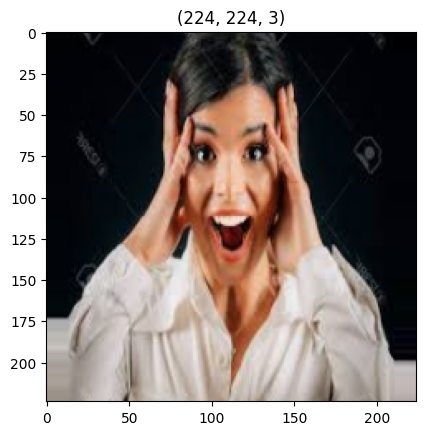

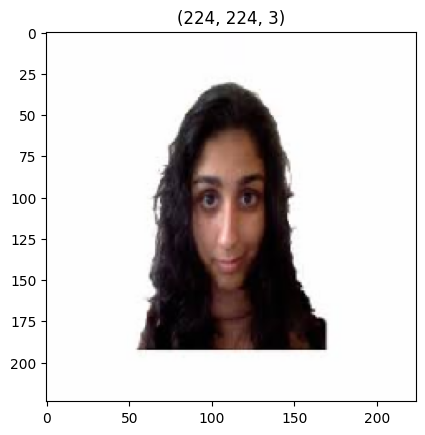

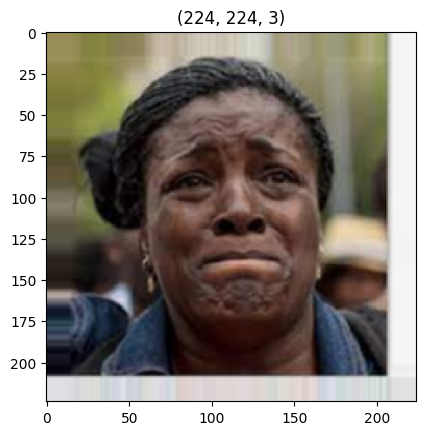

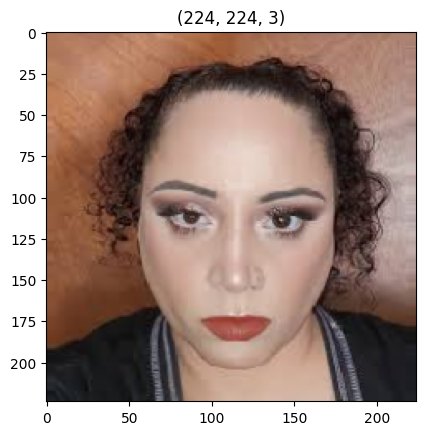

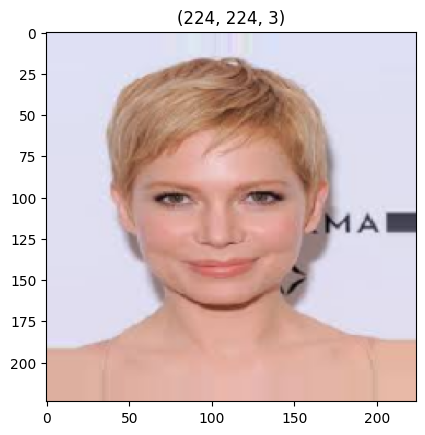

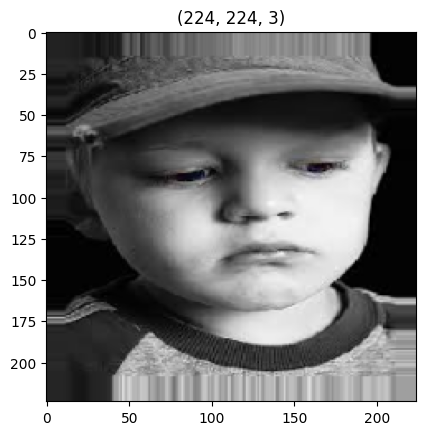

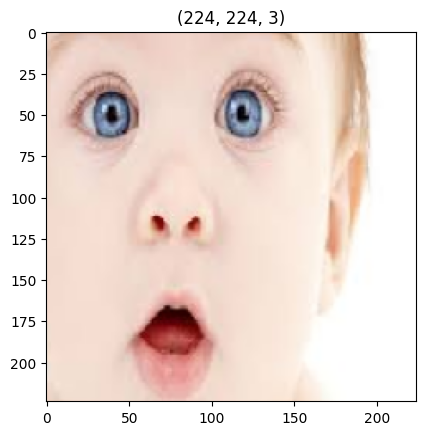

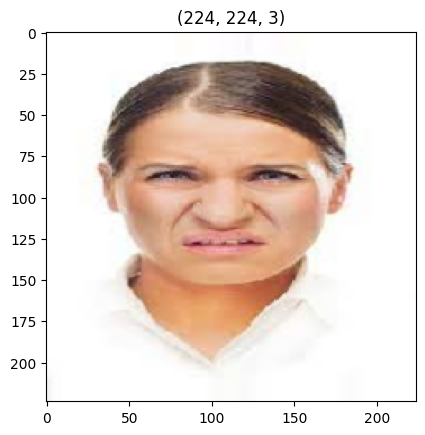

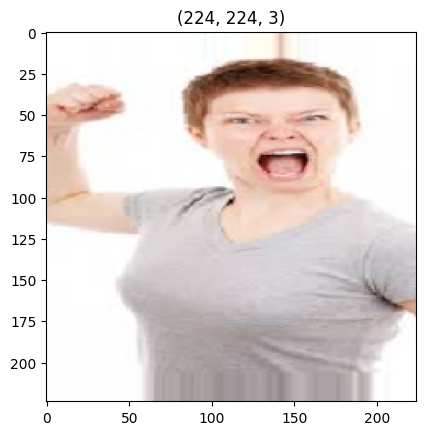

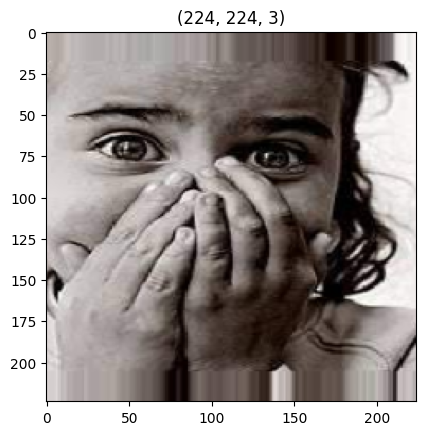

In [31]:
# to visualize the images in the traing data denerator

t_img , label = next(train_data)

#-----------------------------------------------------------------------------
# function when called will prot the images
def plotImages(img_arr, label):
  """
  input  :- images array
  output :- plots the images
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()

    count += 1
    if count == 10:
      break

#-----------------------------------------------------------------------------
# function call to plot the images
plotImages(t_img, label)

# **having early stopping and model check point**

In [53]:
## having early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.keras", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list
call_back = [es, mc]

In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of classes explicitly
num_classes = 7

# Custom generator to convert labels to one-hot encoding
def to_categorical_generator(generator):
    """Converts the target labels in a generator to one-hot encoding."""
    for X, y in generator:
        yield X, tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Configure the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'  # Use 'sparse' for integer labels
)

val_data = val_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'  # Use 'sparse' for integer labels
)

# Wrap the generators
train_data_categorical = to_categorical_generator(train_data)
val_data_categorical = to_categorical_generator(val_data)

# Train the model
hist = model.fit(
    train_data_categorical,
    steps_per_epoch=len(train_data),  # Use the size of the training dataset
    epochs=30,
    validation_data=val_data_categorical,
    validation_steps=len(val_data),  # Use the size of the validation dataset
    callbacks=[es, mc]
)


Found 350 images belonging to 7 classes.
Found 350 images belonging to 7 classes.
Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8684 - loss: 0.6669
Epoch 1: val_accuracy improved from -inf to 0.96000, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8694 - loss: 0.6637 - val_accuracy: 0.9600 - val_loss: 0.1428
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9516 - loss: 0.1451
Epoch 2: val_accuracy improved from 0.96000 to 0.99714, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9525 - loss: 0.1454 - val_accuracy: 0.9971 - val_loss: 0.0059
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9955 - loss: 0.0228
Epoch 3: val_accuracy did not improve from 0.99714
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9951 - loss: 0.0235 - val_accuracy: 0.9914 - val_loss: 0.0212
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9943 - loss: 0.0164
Epoch 4: val_ac

In [58]:
# Loading the best fit model
from keras.models import load_model
model = load_model("/content/best_model.keras")

In [59]:
h =  hist.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

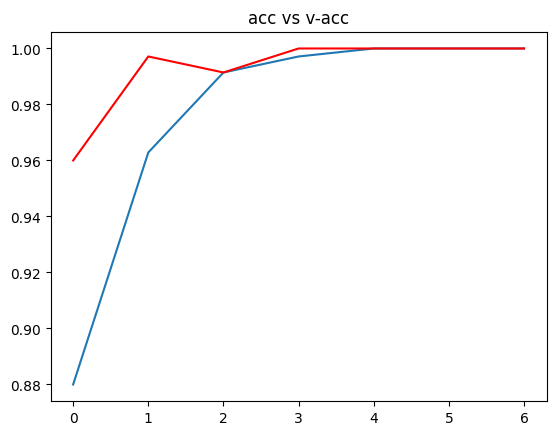

In [60]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

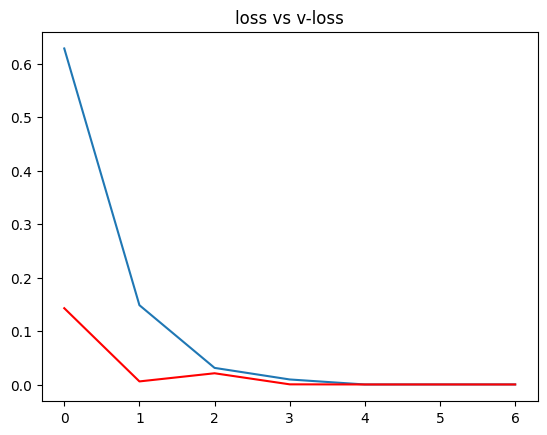

In [61]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [62]:
# just to map o/p values
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
 the image is of Angry


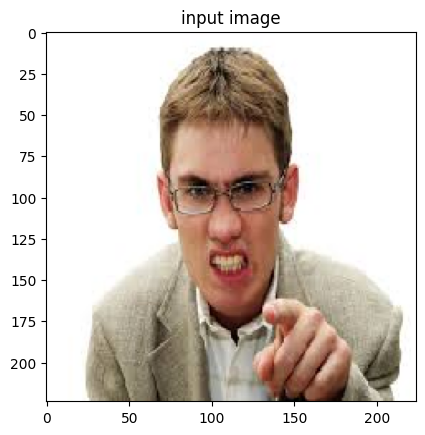

In [67]:
# path for the image to see if it predics correct class

path = "/content/train/Angry/images (38).jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
 the image is of Happy


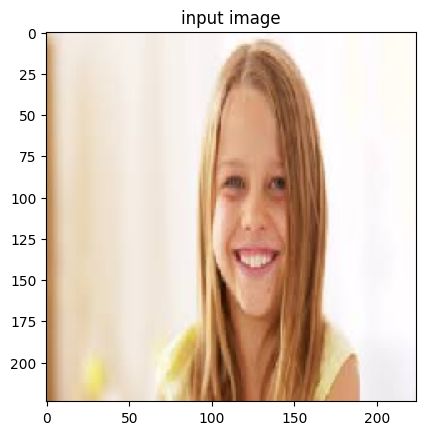

In [68]:
# path for the image to see if it predics correct class

path = "/content/train/Happy/images (1).jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
 the image is of Disguist


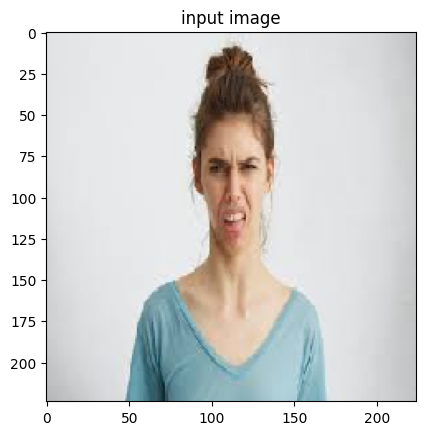

In [69]:
# path for the image to see if it predics correct class

path = "/content/train/Disguist/download (1).jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
 the image is of Neutral


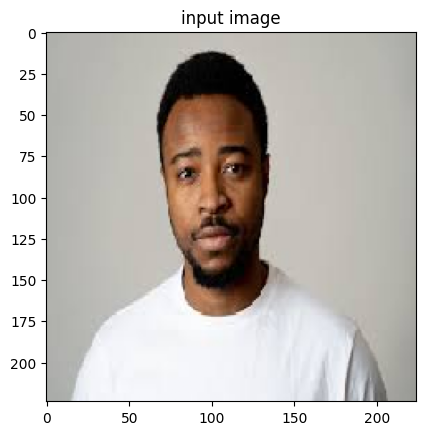

In [70]:
# path for the image to see if it predics correct class

path = "/content/train/Neutral/download (1).jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()